Мартиросян Завен   
martirosian.z@mail.ru

#Часть первая, с блекджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
import scipy
from tqdm import tqdm

plt.style.use('ggplot')
env = gym.make('Blackjack-v0')
env.natural = True

%matplotlib inline

1 Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
env = gym.make('Blackjack-v0', natural=True)
eval_episodes_num = 1_000_000
actions = {'stick': 0,'hit': 1}

In [3]:
def play_simple_strategy(env):
    score, dealer_card, usable_ace = env.reset()
    while score < 19:
        observation, reward, done, info = env.step(actions['hit'])
        score, dealer_card, usable_ace = observation
    else:
        observation, reward, done, info = env.step(actions['stick'])
        score, dealer_card, usable_ace = observation
    return reward

In [6]:
rewards = np.array([play_simple_strategy(env) for i in range(eval_episodes_num)])
print("Средний выигрыш при очень простой стратегии: ", rewards.mean())

Средний выигрыш при очень простой стратегии:  -0.0411565


2. Реализуйте метод обучения с подкреплением без модели

In [7]:
env = gym.make('Blackjack-v0', natural=True)
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-1, 1]

In [8]:
def get_random_reward(reward_range, shape=None):
    return np.random.random(shape) * (reward_range[1] - reward_range[0]) + reward_range[0]

def init_Q():
    Q = get_random_reward(reward_range, shape=observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    return Q

def compute_policy_by_Q(Q):
    return Q.argmax(axis=-1)

def get_idxs(s, a=None):
    if a is not None:
        return s[0], s[1], int(s[2]), a
    else:
        return s[0], s[1], int(s[2])

In [9]:
def play_pi_strategy(env, pi):
    "Play episode in env with stategy pi"
    s = env.reset()
    done = False
    for _ in range(32):
        s, reward, done, info = env.step(pi[get_idxs(s)])
        if done:
            break
    return reward

In [10]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=0.9):
    s = env.reset()
    a = pi[get_idxs(s)] if np.random.rand() > epsilon else env.action_space.sample()
    
    for _ in range(32):
        s_prime, reward, done, info = env.step(a)
        a_prime = pi[get_idxs(s_prime)] if np.random.rand() > epsilon else env.action_space.sample()
        Q[get_idxs(s, a)] = Q[get_idxs(s, a)] + alpha * (reward + gamma * np.max( Q[get_idxs(s_prime)] ) - Q[get_idxs(s, a)])
        s, a = s_prime, a_prime
        if done:
            break

In [13]:
def train_Q_learning_model(
    env, alpha=0.05, epsilon=0.05, gamma=0.9,
    train_episodes_num=500_000, eval_episodes_num=100_000, eval_interval=10_000):
  
    Q = init_Q()
    pi = compute_policy_by_Q(Q)
    avg_rewards = []
    episodes = []
    t_train_episodes_num = tqdm(range(1, train_episodes_num + 1))
    for i in t_train_episodes_num:
        Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma)
        pi = compute_policy_by_Q(Q)
        if not i % eval_interval:
            rewards = np.array([play_pi_strategy(env, pi) for i in range(eval_episodes_num)])
            avg_reward = rewards.mean()
            avg_rewards.append(avg_reward)
            episodes.append(i)
            t_train_episodes_num.set_postfix(avg_reward=avg_reward)
    avg_rewards = np.array(avg_rewards)
    episodes = np.array(episodes)
    return avg_rewards, episodes, pi

In [14]:
alpha = 0.05
epsilon = 0.05
gamma = 0.9 
train_episodes_num=1_000_000 
avg_rewards, episodes, pi = train_Q_learning_model(env, train_episodes_num=train_episodes_num, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 1000000/1000000 [10:45<00:00, 1548.57it/s, avg_reward=-.112]


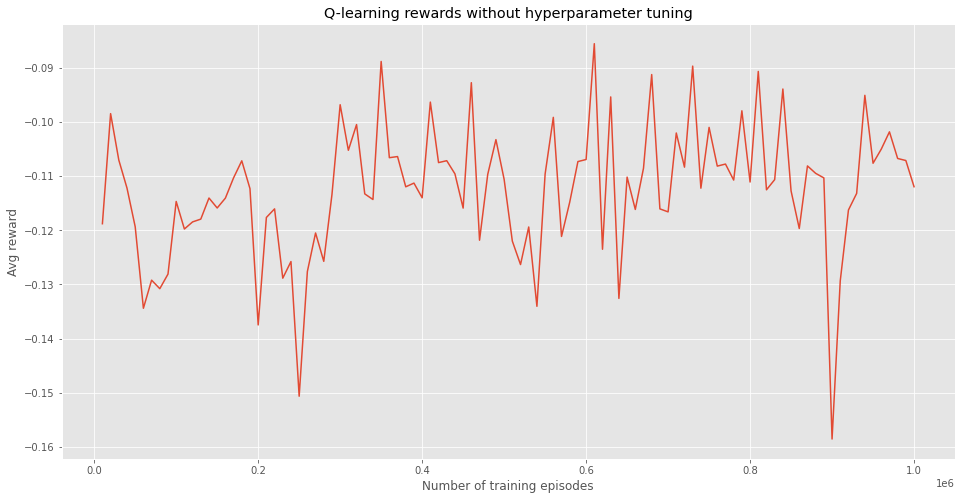

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

In [16]:
avg_rewards[-1]

-0.111955

3.1 Попробуйте подобрать оптимальные гиперпараметры.

In [17]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.05]
epsilon = 0.05
gamma = 0.9
train_episodes_num=500_000
for alpha in alphas:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma, train_episodes_num=train_episodes_num)
    print(f'alpha:{alpha}\t best avg reward:{avg_rewards.max()}')

100%|██████████| 500000/500000 [04:59<00:00, 1672.09it/s, avg_reward=-.29]


alpha:1e-05	 best avg reward:-0.278325


100%|██████████| 500000/500000 [04:56<00:00, 1685.18it/s, avg_reward=-.142]


alpha:0.0001	 best avg reward:-0.141925


100%|██████████| 500000/500000 [05:03<00:00, 1644.81it/s, avg_reward=-.103]


alpha:0.001	 best avg reward:-0.09236


100%|██████████| 500000/500000 [05:18<00:00, 1570.15it/s, avg_reward=-.122]


alpha:0.01	 best avg reward:-0.098535


100%|██████████| 500000/500000 [05:26<00:00, 1530.01it/s, avg_reward=-.106]

alpha:0.05	 best avg reward:-0.086445


In [18]:
alpha = 0.05
epsilons = [0.01, 0.1, 0.5, 0.75, 0.9, 0.99]
gamma = 0.9

for epsilon in epsilons:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'epsilon:{epsilon}\t best avg reward:{avg_rewards.max()}')

100%|██████████| 500000/500000 [05:23<00:00, 1544.75it/s, avg_reward=-.121]


epsilon:0.01	 best avg reward:-0.10693


100%|██████████| 500000/500000 [05:22<00:00, 1549.28it/s, avg_reward=-.105]


epsilon:0.1	 best avg reward:-0.077095


100%|██████████| 500000/500000 [05:19<00:00, 1565.40it/s, avg_reward=-.0745]


epsilon:0.5	 best avg reward:-0.06232


100%|██████████| 500000/500000 [05:18<00:00, 1568.45it/s, avg_reward=-.0834]


epsilon:0.75	 best avg reward:-0.062305


100%|██████████| 500000/500000 [05:18<00:00, 1568.88it/s, avg_reward=-.0988]


epsilon:0.9	 best avg reward:-0.058875


100%|██████████| 500000/500000 [05:19<00:00, 1565.98it/s, avg_reward=-.116]

epsilon:0.99	 best avg reward:-0.06189


In [19]:
alpha = 0.05
epsilon = 0.9
gammas = [0.01, 0.05, 0.1, 0.5, 0.7, 0.9, 0.95]

for gamma in gammas:
    avg_rewards, episodes, pi = train_Q_learning_model(env, alpha=alpha, epsilon=epsilon, gamma=gamma)
    print(f'gamma:{gamma}\t best avg reward:{avg_rewards.max()}')

100%|██████████| 500000/500000 [05:12<00:00, 1601.83it/s, avg_reward=-.0357]


gamma:0.01	 best avg reward:-0.031325


100%|██████████| 500000/500000 [05:13<00:00, 1595.45it/s, avg_reward=-.0364]


gamma:0.05	 best avg reward:-0.03193


100%|██████████| 500000/500000 [05:13<00:00, 1597.04it/s, avg_reward=-.0443]


gamma:0.1	 best avg reward:-0.03027


100%|██████████| 500000/500000 [05:16<00:00, 1577.46it/s, avg_reward=-.0423]


gamma:0.5	 best avg reward:-0.026665


100%|██████████| 500000/500000 [05:17<00:00, 1576.92it/s, avg_reward=-.0568]


gamma:0.7	 best avg reward:-0.0425


100%|██████████| 500000/500000 [05:17<00:00, 1575.13it/s, avg_reward=-.137]


gamma:0.9	 best avg reward:-0.056355


100%|██████████| 500000/500000 [05:15<00:00, 1584.95it/s, avg_reward=-.0937]

gamma:0.95	 best avg reward:-0.07065


In [21]:
alpha = 0.05
epsilon = 0.9
gamma = 0.5

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=1_000_000
)

100%|██████████| 1000000/1000000 [10:25<00:00, 1597.52it/s, avg_reward=-.0376]


3.2 Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. 

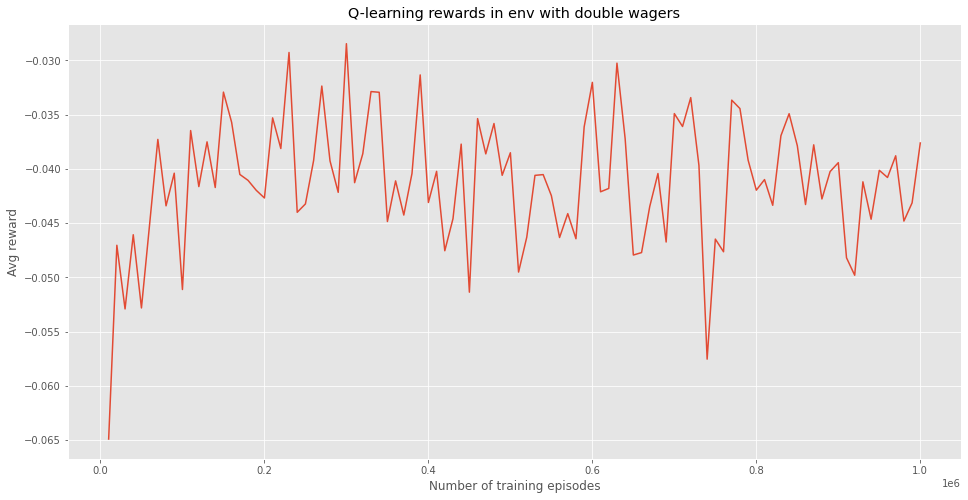

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

In [27]:
print('Средняя награда=', avg_rewards[-1])

Средняя награда= -0.037615


In [24]:
env.close()

#Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:  
  <b>double</b> — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [46]:
from gym.envs.toy_text.blackjack import *


class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.      
        elif action == 2:  # double: double wager, add a card to players hand, play out the dealers hand, and score
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
                else:
                    reward *= 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

5.1 Реализуйте метод обучения с подкреплением без модели для этого варианта.

In [47]:
env = DoubleBlackjackEnv(natural=True)

In [48]:
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-2, 2]

In [53]:
def init_Q():
    Q = get_random_reward(reward_range, shape=observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) > 21, ..., 2] = -2
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    Q[np.arange(observation_space_shape[0]) == 21, ..., 2] = 2
    return Q

def get_idxs(s, a=None):
    if a is not None:
        return s[0], s[1], int(s[2]), a
    else:
        return s[0], s[1], int(s[2])

In [54]:
alpha = 0.05
epsilon = 0.9
gamma = 0.5

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=2_000_000
)

100%|██████████| 2000000/2000000 [20:42<00:00, 1609.77it/s, avg_reward=-.0327]


5.2 Постройте графики, аналогичные п.2.

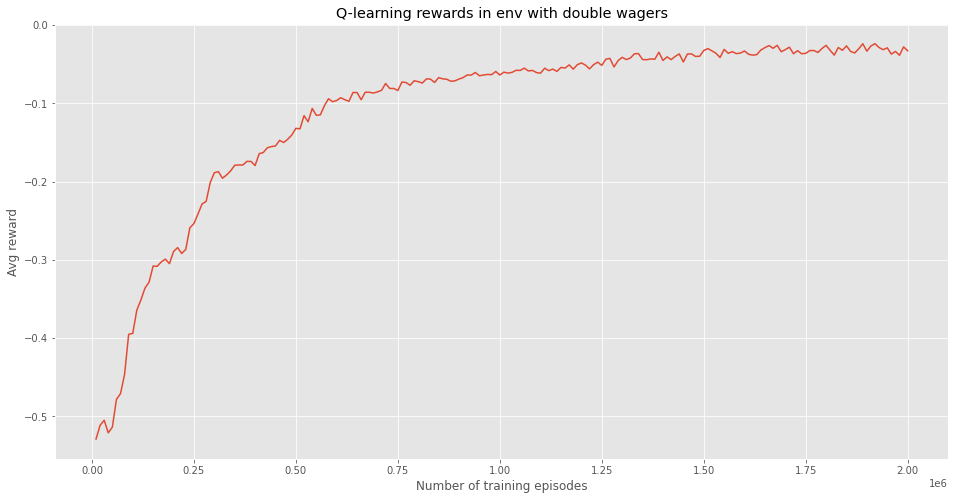

In [55]:
plt.figure(figsize=(16, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');

In [56]:
print('Средняя награда=', avg_rewards[-1])

Средняя награда= -0.032725


Примерно также, как и без возможности удвоения ставки.

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [57]:
from gym.envs.toy_text.blackjack import *

full_deck = np.tile(np.concatenate([np.arange(1, 10), np.repeat(10, 4)]), 4)

card_to_value = {
    1: -1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 0,
    8: 0,
    9: 0,
    10: -1,
}

def get_idxs(s, a=None):
    if a is not None:
        return s[0], s[1], int(s[2]), s[3], a
    else:
        return s[0], s[1], int(s[2]), s[3]

class DoubleCountBlackjackEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(41)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
        self.deck = self.np_random.permutation(full_deck)
        self.card_idx = 0
        self.cnt = 0
        
        # Start the first game
        self.reset()
        
    def draw_card(self, count=True):
        card = self.deck[self.card_idx]
        self.card_idx += 1
        if count:
            self.cnt += card_to_value[card]
        return card
    
    def draw_hand(self, player_hand=True):
        return [self.draw_card(), self.draw_card(player_hand)]
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.      
        elif action == 2:  # double: double wager, add a card to players hand, play out the dealers hand, and score
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -2.
            else:
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1.:
                    reward = 1.5
                else:
                    reward *= 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cnt)
    
    def reset(self):
        if hasattr(self, 'dealer'):
            self.cnt += card_to_value[self.dealer[1]]
        
        if len(self.deck) - self.card_idx < 15:
            self.deck = self.np_random.permutation(full_deck)
            self.card_idx = 0
            self.cnt = 0
    
        self.dealer = self.draw_hand(player_hand=False)
        self.player = self.draw_hand()
        return self._get_obs()

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [58]:
def init_Q():
    Q = np.zeros(observation_space_shape + action_space_shape)
    Q[np.arange(observation_space_shape[0]) > 21] = -1
    Q[np.arange(observation_space_shape[0]) > 21, ..., 2] = -2
    Q[np.arange(observation_space_shape[0]) == 21] = 1
    Q[np.arange(observation_space_shape[0]) == 21, ..., 2] = 2
    return Q

In [59]:
env = DoubleCountBlackjackEnv(natural=True)

In [60]:
action_space_shape = [env.action_space.n]
observation_space_shape = [discrete_space.n for discrete_space in env.observation_space]
reward_range = [-2, 2]

In [61]:
alpha = 0.05
epsilon = 0.9
gamma = 0.5

avg_rewards, episodes, pi = train_Q_learning_model(
    env, alpha=alpha, epsilon=epsilon, gamma=gamma,
    train_episodes_num=2_000_000
)

100%|██████████| 2000000/2000000 [19:37<00:00, 1697.84it/s, avg_reward=-.0553]


Постройте графики, аналогичные п.2.

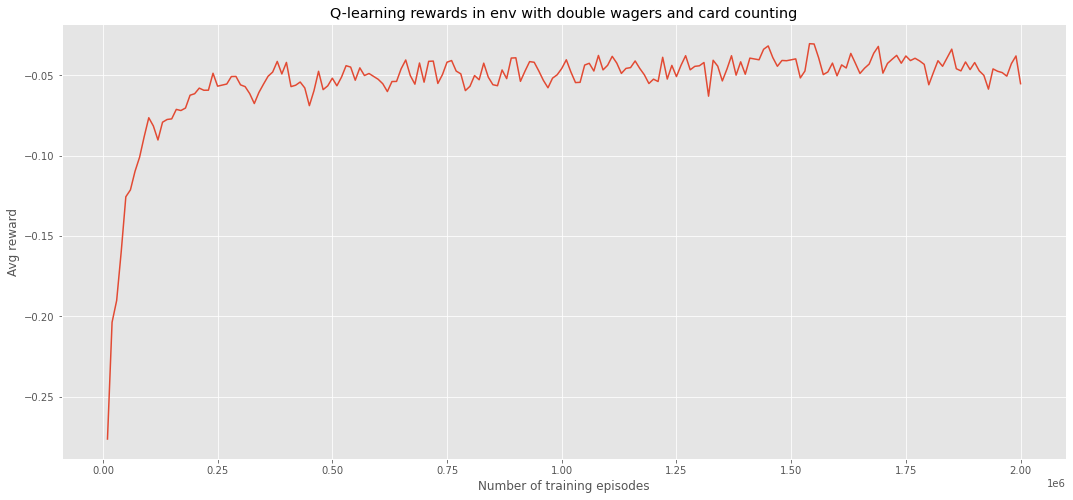

In [63]:
plt.figure(figsize=(18, 8))
plt.plot(episodes, avg_rewards)
plt.title('Q-learning rewards in env with double wagers and card counting')
plt.xlabel('Number of training episodes');
plt.ylabel('Avg reward');


И с подсчетом карт казино обыгрывает.